# 취업 관련 데이터 크롤링: 사람인

## 2020.06.11.

### A반 최예라

## 목차
0. 셋업
1. 사람인 URL 구조 파악 및 관련 정보 정리
2. 검색 데이터 얻기
3. 공고 정보 얻기
4. Google Caldendar API로 지원 마감 일정 달력에 추가하기

## 0. 셋업
1. 주요 패키지 로드
2. 추가 설치
3. 함수 작성

### 0-1. 주요 패키지 로드

In [1]:
# 주요 패키지 로드
# 파이썬 표준 라이브러리 모듈
from collections import defaultdict
# import datetime
from datetime import datetime, timedelta
import glob
import json
import os
import time
from urllib.request import urlretrieve
from urllib.parse import urlparse, urlencode, parse_qs, quote, unquote

# 서드파티 모듈
from bs4 import BeautifulSoup as BS
from IPython.display import Markdown, display, Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import requests
from selenium import webdriver

### 0-2. 추가 설치
* **`nbextensions`**: 주피터 노트북 익스텐션 설치, 관리, 설정 가능
* **`RISE`**: HTML 기반 프리젠테이션에 사용되는 `reveal.js`를 주피터 노트북에 적용해 바로 프리젠테이션을 할 수 있게 해주는 익스텐션

In [2]:
# !conda install -c conda-forge jupyter_contrib_nbextensions
# !conda install -c conda-forge rise
# !pip install RISE

### 0-3. 함수 작성
* **`get_soup`**: URL, parameter, header 정보 넣어주면 soup 객체를 리턴하는 함수
    - GET 결과 코드가 200이 아닌 경우 해당 정보를 출력

In [4]:
def get_soup(url, params='', headers=''):
    resp = requests.get(url, params=params, headers=headers)
    if resp.status_code == 200:
        soup = BS(resp.text)
        return soup
    else:
        print('status_code != 200')

## 1. 사람인 URL 구조 파악 및 관련 정보 정리
1. 기본 구조 파악
2. soup 분석
3. 데이터 정리 및 저장

### 1-1. 기본 구조 파악
* 사람인 사이트는 여러 단계로 잘 구조화되어 있음.

#### 지역별

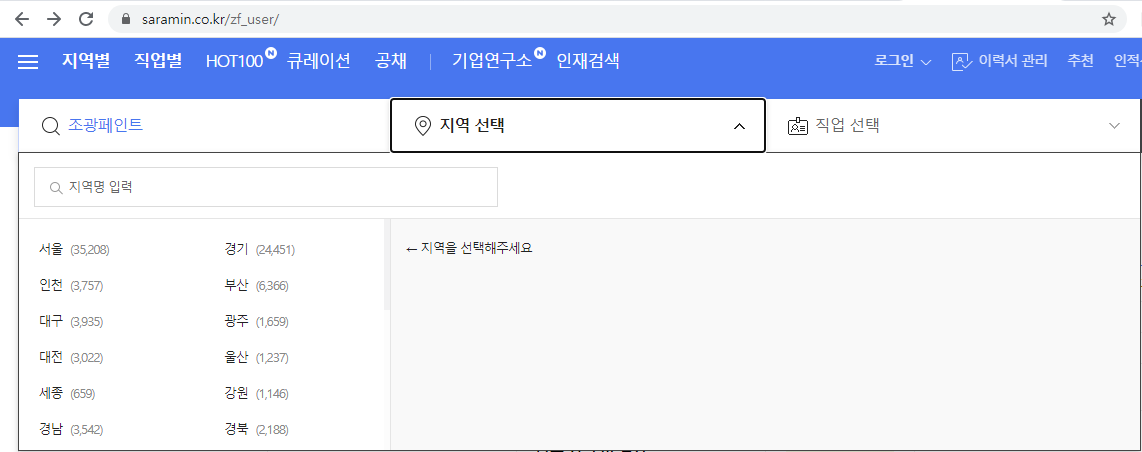

In [5]:
display(Image('./images/saramin_01_regions.png'))

#### 직업별

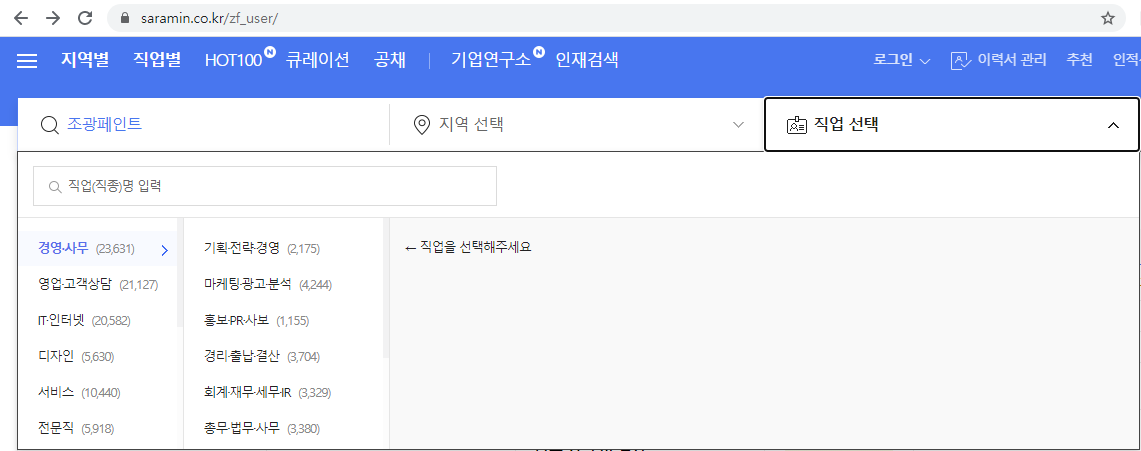

In [6]:
display(Image('./images/saramin_02_jobs.png'))

### 1-2. soup 분석

In [7]:
base_url = 'http://www.saramin.co.kr/zf_user/jobs/list/domestic'
soup = get_soup(base_url)

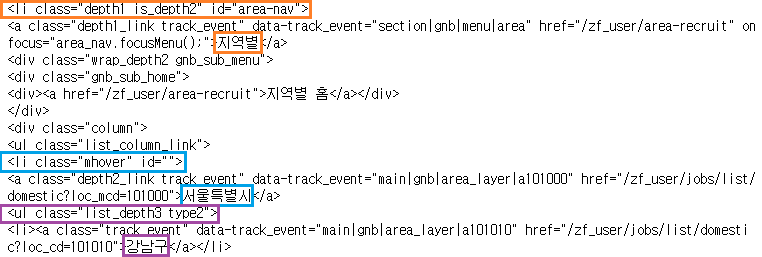

In [8]:
display(Image('./images/saramin_03_soup_hierarchy.png'))

 #### 1단계: 카테고리별 분류
 * 예) 지역별, 직업별, ... 등
 * **상황**: `<li class="depth1 is_depth2" id="area-nav">` 등과 같이 `li.depth1`에서 하위 분류를 감싸고 있음
 * **해결**: `soup.find_all('li', class_="depth1")`로 각 원소가 카테고리별 태그 전체인 리스트를 얻을 수 있음

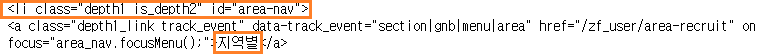

In [9]:
display(Image('./images/saramin_03_soup_hierarchy_d1.png'))

In [10]:
category_tags = soup.find_all('li', class_="depth1") # 카테고리별

for category_tag in category_tags:
    print(category_tag.find('a', class_='depth1_link').text)

지역별
직업별
HOT100
큐레이션
공채
기업연구소
인재검색
전체 채용정보


#### 2단계: 카테고리 내 2단계 레벨별 분류, 우선 지역별/직업별만
* 예) 지역별: 서울특별시, 경기도, ...
* **상황**: 2단계 `li` 태그들이 3단계 태그들을 감싸고 있는데, 모든 2단계 `li`들에 공통된 class/id가 있는 것이 아니었음
* **해결 (1)**: 우선 원하는 `li`들 바로 상위의 `ul` 태그 전체를 `find`로 얻어옴
    - 예) `region_tags = category_tags[0].find('ul', class_='list_column_link')`

* **해결 (2)**: (1) `find_all`의 `recursive=False` 옵션을 적용해 3단계를 제외한 2단계 `li` 태그들만 추출
    - 예) `region_d2_tags = region_tags.find_all('li', recursive=False)`

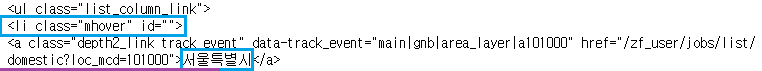

In [11]:
display(Image('./images/saramin_03_soup_hierarchy_d2.png'))

#### 지역별

In [12]:
region_tags = category_tags[0].find('ul', class_='list_column_link')
region_d2_tags = region_tags.find_all('li', recursive=False)

#### 직업별

In [13]:
job_tags = category_tags[1].find('ul', class_='list_column_link')
job_d2_tags = job_tags.find_all('li', recursive=False)

#### 3단계: 카테고리 내 3단계 레벨 분류
* 예) 서울특별시: 관악구, 광진구, ...
* **상황**: `<ul class="list_depth3 type2">` 하위의 `li` 각각에 3단계 레벨 태그들이 포함되어 있음
* **해결**: `for`문을 이용해 `job_depth2_li_list`의 2단계 `li` 태그별로 3단계 `li` 리스트 추출
    - 예) `region_d3_tags = region_d2_tag.find('ul', class_='list_depth3').find_all('li')`

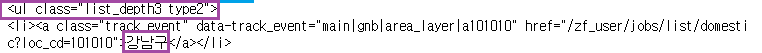

In [14]:
display(Image('./images/saramin_03_soup_hierarchy_d3.png'))

### 1-3. 데이터 정리 및 저장
#### 지역별 데이터 정리 및 저장

In [15]:
region_info = []

for region_d2_tag in region_d2_tags:
    region_dict = {}
    
    # get info for region d2
    region_d2_a = region_d2_tag.find('a', recursive=False)
    region_d2_name = region_d2_a.text # 서울특별시
    region_d2_url = region_d2_a.get('href')
    
    region_dict = {
        'name':region_d2_name,
        'url': region_d2_url,
        'subregions': []
    }
    
    # get info for regions d3
    region_d3_tags = region_d2_tag.find('ul', class_='list_depth3').find_all('li')
    for region_d3_tag in region_d3_tags:
        region_d3_a = region_d3_tag.find('a', recursive=False)
        region_d3_name = region_d3_a.text # 관악구
        region_d3_url = region_d3_a.get('href')
        
        region_dict['subregions'].append({
            'name': region_d3_name,
            'url': region_d3_url
        })
    
    region_info.append(region_dict)

#### json 파일로 저장하기/불러오기

In [19]:
region_info_json = 'region_info.json'

# with open(region_info_json, 'w') as f:
#     json.dump(region_info, f)
    
with open(region_info_json, 'r') as f:
    region_info = json.loads(f.read())

#### pandas dataframe으로 보기

In [21]:
region_df = pd.DataFrame(region_info)
region_df.head()

,name,url,subregions
0,서울특별시,/zf_user/jobs/list/domestic?loc_mcd=101000,"[{'name': '강남구', 'url': '/zf_user/jobs/list/do..."
1,경기도,/zf_user/jobs/list/domestic?loc_mcd=102000,"[{'name': '가평군', 'url': '/zf_user/jobs/list/do..."
2,인천광역시,/zf_user/jobs/list/domestic?loc_mcd=108000,"[{'name': '강화군', 'url': '/zf_user/jobs/list/do..."
3,부산광역시,/zf_user/jobs/list/domestic?loc_mcd=106000,"[{'name': '강서구', 'url': '/zf_user/jobs/list/do..."
4,대구광역시,/zf_user/jobs/list/domestic?loc_mcd=104000,"[{'name': '남구', 'url': '/zf_user/jobs/list/dom..."


#### 직업별 데이터 정리 및 저장

In [22]:
job_info = []

for job_d2_tag in job_d2_tags:
    job_dict = {}
    
    # get info for job d2
    job_d2_a = job_d2_tag.find('a', recursive=False)
    job_d2_name = job_d2_a.text # IT∙인터넷
    job_d2_url = job_d2_a.get('href')
    
    job_dict = {
        'name':job_d2_name,
        'url': job_d2_url,
        'subjobs': []
    }
    
    # get info for jobs d3
    job_d3_tags = job_d2_tag.find('ul', class_='list_depth3').find_all('li')
    for job_d3_tag in job_d3_tags:
        job_d3_a = job_d3_tag.find('a', recursive=False)
        job_d3_name = job_d3_a.text # 관악구
        job_d3_url = job_d3_a.get('href')
        
        job_dict['subjobs'].append({
            'name': job_d3_name,
            'url': job_d3_url
        })
    
    job_info.append(job_dict)

#### json 파일로 저장하기/불러오기

In [25]:
job_info_json = 'job_info.json'

# with open(job_info_json, 'w') as f:
#     json.dump(job_info, f)

with open(job_info_json, 'r') as f:
    job_info = json.loads(f.read())

#### pandas dataframe으로 보기

In [27]:
job_df = pd.DataFrame(job_info)
job_df.head()

,name,url,subjobs
0,경영∙사무,/zf_user/jobs/list/job-category?cat_bcd=1,"[{'name': '기획∙전략∙경영', 'url': '/zf_user/jobs/li..."
1,영업∙고객상담,/zf_user/jobs/list/job-category?cat_bcd=2,"[{'name': '일반영업', 'url': '/zf_user/jobs/list/j..."
2,IT∙인터넷,/zf_user/jobs/list/job-category?cat_bcd=4,"[{'name': '웹개발', 'url': '/zf_user/jobs/list/jo..."
3,디자인,/zf_user/jobs/list/job-category?cat_bcd=12,"[{'name': '그래픽디자인∙CG', 'url': '/zf_user/jobs/l..."
4,서비스,/zf_user/jobs/list/job-category?cat_bcd=11,"[{'name': '웨딩∙행사∙이벤트', 'url': '/zf_user/jobs/l..."


In [29]:
pd.DataFrame(job_df['subjobs'][0])

,name,url
0,기획∙전략∙경영,/zf_user/jobs/list/job-category?cat_cd=101
1,마케팅∙광고∙분석,/zf_user/jobs/list/job-category?cat_cd=119
2,홍보∙PR∙사보,/zf_user/jobs/list/job-category?cat_cd=104
3,경리∙출납∙결산,/zf_user/jobs/list/job-category?cat_cd=103
4,회계∙재무∙세무∙IR,/zf_user/jobs/list/job-category?cat_cd=114
5,총무∙법무∙사무,/zf_user/jobs/list/job-category?cat_cd=102
6,비서∙안내∙수행원,/zf_user/jobs/list/job-category?cat_cd=107
7,인사∙교육∙노무,/zf_user/jobs/list/job-category?cat_cd=113
8,사무보조∙문서작성,/zf_user/jobs/list/job-category?cat_cd=108
9,전시∙컨벤션∙세미나,/zf_user/jobs/list/job-category?cat_cd=120


## 2. 검색 데이터 얻기
1. 사람인 검색 결과 URL 분석
2. 주요 파라미터 이용해 검색 요청하고 결과 크롤링하기

### 2-1. 사람인 검색 결과 URL 분석

In [30]:
url_raw = 'http://www.saramin.co.kr/zf_user/jobs/list/domestic?loc_mcd=101000&cat_cd=417&panel_type=&search_optional_item=n&search_done=y&panel_count=y'
parse_qs(url_raw)

{'http://www.saramin.co.kr/zf_user/jobs/list/domestic?loc_mcd': ['101000'],
 'cat_cd': ['417'],
 'search_optional_item': ['n'],
 'search_done': ['y'],
 'panel_count': ['y']}

In [31]:
url_raw2 = 'http://www.saramin.co.kr/zf_user/jobs/list/domestic?loc_mcd=101000%2C102000&cat_cd=417'
parse_qs(url_raw2)

{'http://www.saramin.co.kr/zf_user/jobs/list/domestic?loc_mcd': ['101000,102000'],
 'cat_cd': ['417']}

In [32]:
# comma 로 구분된 값 quote 처리(comma가 %2C로)해서 적절한 parameter에 넣어주는 것으로 여러 조건 검색 가능
quote('101000,102000')

'101000%2C102000'

In [33]:
url_raw3 = 'http://www.saramin.co.kr/zf_user/jobs/list/domestic?page=2&loc_mcd=101000%2C102000&cat_cd=417&search_optional_item=n&search_done=y&panel_count=y&isAjaxRequest=0&page_count=50&sort=RL&type=domestic&is_param=1&isSearchResultEmpty=1&isSectionHome=0&searchParamCount=2#searchTitle'
parse_qs(url_raw3)

{'http://www.saramin.co.kr/zf_user/jobs/list/domestic?page': ['2'],
 'loc_mcd': ['101000,102000'],
 'cat_cd': ['417'],
 'search_optional_item': ['n'],
 'search_done': ['y'],
 'panel_count': ['y'],
 'isAjaxRequest': ['0'],
 'page_count': ['50'],
 'sort': ['RL'],
 'type': ['domestic'],
 'is_param': ['1'],
 'isSearchResultEmpty': ['1'],
 'isSectionHome': ['0'],
 'searchParamCount': ['2#searchTitle']}

### 2-2. 주요 파라미터 이용해 검색 요청하고 결과 크롤링하기

In [79]:
base_url = 'http://www.saramin.co.kr/zf_user/jobs/list/domestic'

params = {
    'loc_mcd': ['101000,102000'],
    'cat_cd': '417',
    'page': '1',
    'page_count': '1000',
    'searchword': '인공지능'
}

headers = {
    'referer': 'http://www.saramin.co.kr/zf_user/jobs/list/domestic'
}

In [80]:
search_resp = requests.get(base_url, params=params, headers=headers)
search_resp

<Response [200]>

In [ ]:
search_soup = BS(search_resp.text)

In [82]:
search_resp.url

'http://www.saramin.co.kr/zf_user/jobs/list/domestic?loc_mcd=101000%2C102000&cat_cd=417&page=1&page_count=1000&searchword=%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5'

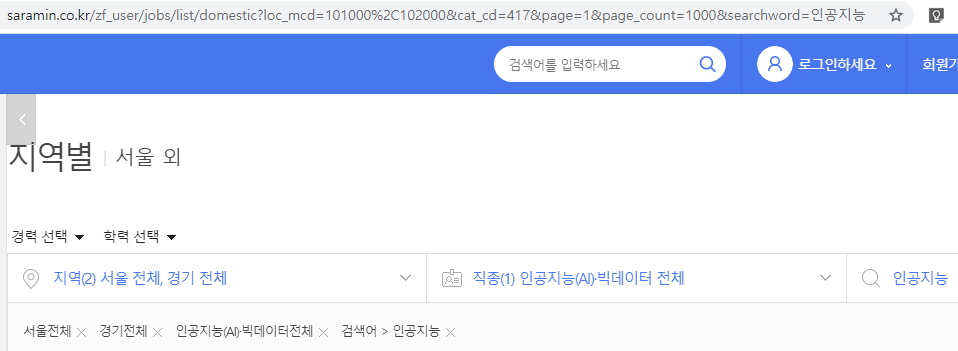

In [77]:
display(Image('./images/saramin_04_search_res1.png'))

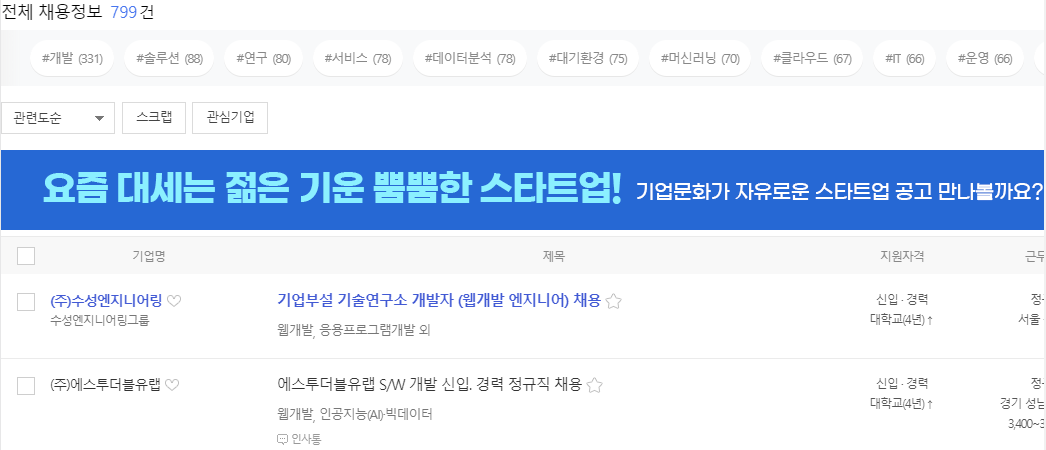

In [84]:
display(Image('./images/saramin_04_search_res2.png'))

In [83]:
len(search_soup.find('div', class_='list_body').find_all('div', class_='list_item'))

799

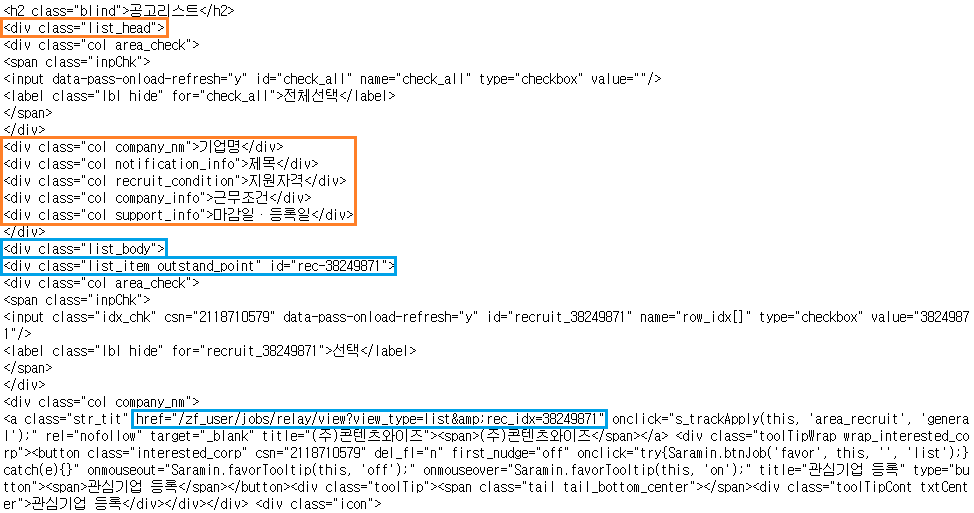

In [40]:
display(Image('./images/saramin_05_search_soup.png'))

In [41]:
table_headers = [header.text for header in search_soup.find('div', class_='list_head').find_all('div')[1:]]
table_headers

['기업명', '제목', '지원자격', '근무조건', '마감일·등록일']

In [ ]:
table_jobs_raw = search_soup.find('div', class_='list_body').find_all('div', class_='list_item')

In [43]:
rec_idx_list = list(set([job.find('a').get('href').split('rec_idx=')[-1] for job in table_jobs_raw]))
print(rec_idx_list[1:10])
print(len(rec_idx_list))

['38263081', '38245293', '38122311', '38093223', '38161360', '38270141', '38254283', '38199494', '38040489']
795


## 3. 공고 정보 얻기
1. 공고 URL로 요청하기
2. 내부 iframe의 상세 내용 가져오기
3. 공고 정보 깔끔하게 가져오기

### 3-1. 공고 URL로 요청하기

In [44]:
jobpost_url_raw = 'http://www.saramin.co.kr/zf_user/jobs/relay/view?isMypage=no&rec_idx=38249871&recommend_ids=eJxdkLkRBCEMBKM5X%2F9jbyDkn8WxFBLUmq2ZBpU4iBjRhxr%2B%2FOELh6wBklvisLSFgMEZw4A%2BuOskEBJDd%2F1g5RqmV97YPorL5Re2TyF0%2BYWVMzDjyRvb94x3oB%2FcOVB4cp8DVendv68jwjxc6vVM4%2FrM043suLPr8y5dFkSGC80vhOlGnJRMKU8arrbwD%2B%2BXX0Y%3D&view_type=list&gz=1#seq=0'
parse_qs(jobpost_url_raw)

{'http://www.saramin.co.kr/zf_user/jobs/relay/view?isMypage': ['no'],
 'rec_idx': ['38249871'],
 'recommend_ids': ['eJxdkLkRBCEMBKM5X/9jbyDkn8WxFBLUmq2ZBpU4iBjRhxr+/OELh6wBklvisLSFgMEZw4A+uOskEBJDd/1g5RqmV97YPorL5Re2TyF0+YWVMzDjyRvb94x3oB/cOVB4cp8DVendv68jwjxc6vVM4/rM043suLPr8y5dFkSGC80vhOlGnJRMKU8arrbwD++XX0Y='],
 'view_type': ['list'],
 'gz': ['1#seq=0']}

In [45]:
jobpost_base_url = 'http://www.saramin.co.kr/zf_user/jobs/relay/view'

jobpost_params = {
    'rec_idx': '38225764',
}

# jobpost_headers = {}

In [46]:
jobpost_resp = requests.get(jobpost_base_url, params=jobpost_params)
jobpost_resp

<Response [200]>

In [ ]:
jobpost_soup = BS(jobpost_resp.text)

### 3-2. 내부 iframe의 상세 내용 가져오기

In [48]:
# 상세 내용: iframe임
# <iframe name="iframe_content_0" id="iframe_content_0" class="iframe_content" width="860" scrolling="no" frameborder="0" marginheight="0" marginwidth="0" src="/zf_user/jobs/relay/view-detail?rec_idx=38249871&amp;rec_seq=0" title="상세요강" height="2665px"></iframe>
# src="/zf_user/jobs/relay/view-detail?rec_idx=38249871&rec_seq=0"
jobpost_detail_base_url = {}
jobpost_soup.find('iframe', {'title': '입사지원'})

<iframe allowtransparency="true" frameborder="0" height="0" id="quick_apply_frame" name="quick_apply_frame" scrolling="no" showlayer="n" src="about:blank" style="" title="입사지원" width="540"></iframe>

In [ ]:
iframe_base_src = 'http://www.saramin.co.kr/zf_user/jobs/relay/view-detail?rec_idx='
iframe_soup = get_soup(iframe_base_src, params=jobpost_params)

#### iframe 내 태그에 style attribute가 있으면 텍스트로 간주하고 가져오기
* 하지만 깔끔하지 않다...

In [85]:
def has_style(tag):
    return tag.has_attr('style')

iframe_table = iframe_soup.find('table')
iframe_text_list = []

for td in iframe_table.find_all(has_style):
    td_text = td.text.strip().replace('\r\n', ' ').replace('\n', ' ')

    iframe_text_list.append(td_text)

In [86]:
print(iframe_text_list)

['지원자격', 'ㆍ국내외 대학 기졸업자 또는 ‘21년 7월1일까지 입사 가능자           ㆍ병역필 또는 면제자           ㆍ해외여행 결격 사유가 없는 자           ㆍ전 모집분야 전공 무관, 어학우수자 우대', '모집분야', '직무 업무 인원   전략 에너지 Retail, 태양광 투자 등 솔루션 미래사업 전략 수립 0명   인사 사업 전략과 연계된 새로운 인사제도 수립 0명   재무 안정적 사업 운영을 위한 자금 계획 수립 및 운영 0명   IR 솔루션 주주가치 극대화를 위한 IR전략수립 0명', '직무 업무 인원   전략 에너지 Retail, 태양광 투자 등 솔루션 미래사업 전략 수립 0명   인사 사업 전략과 연계된 새로운 인사제도 수립 0명   재무 안정적 사업 운영을 위한 자금 계획 수립 및 운영 0명   IR 솔루션 주주가치 극대화를 위한 IR전략수립 0명', '직무', '업무', '인원', '전략', '에너지 Retail, 태양광 투자 등 솔루션 미래사업 전략 수립', '0명', '인사', '사업 전략과 연계된 새로운 인사제도 수립', '0명', '재무', '안정적 사업 운영을 위한 자금 계획 수립 및 운영', '0명', 'IR', '솔루션 주주가치 극대화를 위한 IR전략수립', '0명', '전형절차', '※ 본 채용 전형은 인적성 검사를 진행하지 않습니다.           ※ 합격자 발표는 채용사이트를 통해 진행하며, 세부 일정은 별도 안내 예정입니다.           ※ 상기 일정은 회사 사정에 따라 일부 변경될 수 있습니다.', '서류지원', 'ㆍ접수기간 : 5.28(목) ∼ 6.11(목) 15:00 (한국 시간 기준)           ㆍ접수방법 : www.hanwhain.com', '5.28(목) ∼ 6.11(목) 15:00 (한국 시간 기준)', 'www.hanwhain.com', '면접전형', 'ㆍ실무면접 : Business Case 면접 (당일 Case 안내 예정)           ㆍ임원면접 : 지원서 기반

###  3-3. 공고 정보 깔끔하게 가져오기
#### 주요 함수들
1. 표에 해당하는 `table` tag 부분을 깔끔하게 전처리하는 함수들
    * **`pre_process_table`, `get_spans`**
    * **`process_rows`, `main`**
    * 출처: 아래 링크의 Gene Burinsky의 답변
        + https://stackoverflow.com/questions/28763891/what-should-i-do-when-tr-has-rowspan
    * 수정
        + 텍스트를 깨끗하게 strip
        + 최종 결과 df 첫 줄이 column header가 되게 함

In [65]:
def pre_process_table(table):
    """
    INPUT:
        1. table - a bs4 element that contains the desired table: ie <table> ... </table>
    OUTPUT:
        a tuple of: 
            1. rows - a list of table rows ie: list of <tr>...</tr> elements
            2. num_rows - number of rows in the table
            3. num_cols - number of columns in the table
    Options:
        include_td_head_count - whether to use only th or th and td to count number of columns (default: False)
    """
    rows = [x for x in table.find_all('tr')]

    num_rows = len(rows)

    # get an initial column count. Most often, this will be accurate
    num_cols = max([len(x.find_all(['th','td'])) for x in rows])

    # sometimes, the tables also contain multi-colspan headers. This accounts for that:
    header_rows_set = [x.find_all(['th', 'td']) for x in rows if len(x.find_all(['th', 'td']))>num_cols/2]

    num_cols_set = []

    for header_rows in header_rows_set:
        num_cols = 0
        for cell in header_rows:
            row_span, col_span = get_spans(cell)
            num_cols+=len([cell.getText()]*col_span)

        num_cols_set.append(num_cols)

    num_cols = max(num_cols_set)

    return (rows, num_rows, num_cols)

In [66]:
def get_spans(cell):
        """
        INPUT:
            1. cell - a <td>...</td> or <th>...</th> element that contains a table cell entry
        OUTPUT:
            1. a tuple with the cell's row and col spans
        """
        if cell.has_attr('rowspan'):
            rep_row = int(cell.attrs['rowspan'])
        else: # ~cell.has_attr('rowspan'):
            rep_row = 1
        if cell.has_attr('colspan'):
            rep_col = int(cell.attrs['colspan'])
        else: # ~cell.has_attr('colspan'):
            rep_col = 1 

        return (rep_row, rep_col)

In [67]:
def process_rows(rows, num_rows, num_cols):
    """
    INPUT:
        1. rows - a list of table rows ie <tr>...</tr> elements
    OUTPUT:
        1. data - a Pandas dataframe with the html data in it
    """
    data = pd.DataFrame(np.ones((num_rows, num_cols))*np.nan)
    for i, row in enumerate(rows):
        try:
            col_stat = data.iloc[i,:][data.iloc[i,:].isnull()].index[0]
        except IndexError:
            print(i, row)

        for j, cell in enumerate(row.find_all(['td', 'th'])):
            rep_row, rep_col = get_spans(cell)

            #print("cols {0} to {1} with rep_col={2}".format(col_stat, col_stat+rep_col, rep_col))
            #print("\trows {0} to {1} with rep_row={2}".format(i, i+rep_row, rep_row))

            #find first non-na col and fill that one
            while any(data.iloc[i,col_stat:col_stat+rep_col].notnull()):
                col_stat+=1
                
            # added by YC
            cellText = cell.getText().strip().replace('\n', ', ').replace('  ', '')
            # data.iloc[i:i+rep_row,col_stat:col_stat+rep_col] = cell.getText()
            data.iloc[i:i+rep_row,col_stat:col_stat+rep_col] = cellText
            if col_stat<data.shape[1]-1:
                col_stat+=rep_col

    return data

In [68]:
def main(table):
    rows, num_rows, num_cols = pre_process_table(table)
    df = process_rows(rows, num_rows, num_cols)
    # added by YC to set the first row as column header
    df = df.rename(columns=df.iloc[0])
    df = df.drop(df.index[0])
    return(df)

#### 주요 함수들
2. soup 결과물에서 섹션 제목, 테이블, 텍스트를 추출하는 함수
    * **`getLineDict`**
        - soup 결과물이 `tr` tag들로 구분되어 있는 것을 이용해, 섹션 제목을 key로, 내용(df/텍스트가 포함된 리스트)을 value로 하는 dict로 저장
        - **섹션 제목**: 글씨 크기가 28 px인 경우
        - **테이블**: `table` tag인 경우, 위에 언급한 테이블 전처리 함수 이용해 df로 정리
        - **텍스트**: 그 이외의 경우
        - **`defaultdict` 사용**: `line_dict`에 새로운 key가 입력될 경우 항상 value가 빈 list로 초기화

In [69]:
from collections import defaultdict

def getLineDict(tr_list):
    key = 'default'
    line_dict = defaultdict(list)

    for tr in tr_list:
        if ('font-size:28px' in str(tr)) or ('font-size: 28px' in str(tr)):
            # section_name = tr.text.strip().replace('\n', ' ')
            section_name = tr.text.strip()
            key = section_name

        elif tr.find('table').find('table'):
            table_dict = {}

            table = tr.find('table').find('table')
            table_df = main(table)

            line_dict[key].append(table_df)

        else:
            # text = tr.text.strip().replace('\n', ' ').replace(' ', '')
            text = tr.text.strip()
            line_dict[key].append(text)
        
    return line_dict

#### 주요 함수들
3. soup 결과물에서 위 `getLineDict` 함수 등을 이용해 공고 포스트 유형(테이블/이미지) 및 공고 데이터를 추출하는 함수
    * **`getJobpostData`**
        - **공고 포스트 유형**: soup 결과물에 `table` tag가 포함되어 있으면 tr, `img` tag가 포함되어 있으면 img로 분류
            + **tr 유형**: 테이블/텍스트를 line_dict로 리턴
            + **img 유형**: 이미지 src 리스트를 리턴
            + **그 외**: 오류 메시지

* **`getJobpostData`**
    - **`try/except` 사용**: `try`문으로 line_dict 생성에 필요한 `tr` tag 목록을 찾고, 찾지 못하는 경우 발생하는 `AttributeError`를 `except`문에서 잡아 다시 `img src` 목록을 얻을 수 있는지 `try/except`문으로 확인

In [70]:
def getJobpostData(jobpost_soup):    
    try:
        tr_list = [tr for tr in jobpost_soup.find('table').find_all('tr', recursive=False) 
                   if tr.text.strip()]
        line_dict = getLineDict(tr_list)
        jobpostType = 'tr'
        
        return jobpostType, line_dict
    
    except AttributeError:
        try:
            img_list = [img.get('src') for img in jobpost_soup.select('p > img')]
            jobpostType = 'img'
            
            return jobpostType, img_list
        
        except:
            print('Unexcepted error: check the job post.')

#### 주요 함수들
4. 추출한 공고 데이터를 깔끔하게 보여주기 위한 함수들
    * **`from IPython.display import Markdown, display, Image`** 이 필요
    * **`printmd`**
        - 주피터 노트북에서 출력 결과에 마크다운 문법(볼드체 등)을 적용하기 위한 함수(검색해 찾음)
    * **`prettyPost`**
        - **tr 유형**: 섹션 제목은 볼드체, 테이블은 df, 텍스트는 항목별로 줄바꿈해 출력
        - **img 유형**: 이미지 src 리스트의 이미지를 불러와 출력

In [71]:
from IPython.display import Markdown, display, Image
def printmd(string):
    display(Markdown(string))
    
def prettyPost(jobpost_soup):
    jobpost_type, jobpost_data = getJobpostData(jobpost_soup)
    
    if jobpost_type == 'tr':        
        for key, values in jobpost_data.items():
            print('-' * 80)
            printmd('**' + key + '**')
            for value in values:
                if isinstance(value, pd.DataFrame):
                    display(value)
                else:
                    print(value.strip().replace('ㆍ', '\nㆍ').replace('  ', ''))
            print('\n')

    elif jobpost_type == 'img':
        img_list = jobpost_data
        
        for img in img_list:
            display(Image(url=img))

#### prettyPost 적용 예시

In [72]:
jobpost_base_url = 'http://www.saramin.co.kr/zf_user/jobs/relay/view-detail'

jobpost_params_list = [
    {
        'rec_idx': '38225764',
    },
    {
        'rec_idx': '38238995',
    },
    {
        'rec_idx': '38227569',
    },
]

jobpost_soup_0 = get_soup(jobpost_base_url, params=jobpost_params_list[0])
jobpost_soup_1 = get_soup(jobpost_base_url, params=jobpost_params_list[1])
jobpost_soup_2 = get_soup(jobpost_base_url, params=jobpost_params_list[2])

In [73]:
prettyPost(jobpost_soup_0)

--------------------------------------------------------------------------------


**지원자격**


ㆍ국내외 대학 기졸업자 또는 ‘21년 7월1일까지 입사 가능자

ㆍ병역필 또는 면제자

ㆍ해외여행 결격 사유가 없는 자

ㆍ전 모집분야 전공 무관, 어학우수자 우대


--------------------------------------------------------------------------------


**모집분야**

,직무,업무,인원
1,전략,"에너지 Retail, 태양광 투자 등 솔루션 미래사업 전략 수립",0명
2,인사,사업 전략과 연계된 새로운 인사제도 수립,0명
3,재무,안정적 사업 운영을 위한 자금 계획 수립 및 운영,0명
4,IR,솔루션 주주가치 극대화를 위한 IR전략수립,0명




--------------------------------------------------------------------------------


**전형절차**

※ 본 채용 전형은 인적성 검사를 진행하지 않습니다.
※ 합격자 발표는 채용사이트를 통해 진행하며, 세부 일정은 별도 안내 예정입니다.
※ 상기 일정은 회사 사정에 따라 일부 변경될 수 있습니다.


--------------------------------------------------------------------------------


**서류지원**


ㆍ접수기간 : 5.28(목) ∼ 6.11(목) 15:00 (한국 시간 기준)

ㆍ접수방법 : www.hanwhain.com


--------------------------------------------------------------------------------


**면접전형**


ㆍ실무면접 : Business Case 면접 (당일 Case 안내 예정)

ㆍ임원면접 : 지원서 기반의 인성 면접

※ 면접은 동일한 날짜에 진행 예정이며, 대면으로 진행하되, 코로나 예방을 위한 체온측정, 마스크 착용 등 
     안전지침은 별도 전달 예정 입니다


--------------------------------------------------------------------------------


**인턴근무**


ㆍ인턴기간 : 6.29(월) ∼ 8.21(금) 8주

ㆍ근무지 : 서울 을지로 한화빌딩

ㆍ처우 : 급여 및 식대 별도 지급

※ 4주 경과 시점에 개인별 면담을 통해 추가 인턴근무 가능 여부에 대해 협의 예정이며, 본인과 해당 부서의 의견에 
     따라 최대 4주까지 추가 인턴 근무 가능 합니다.


--------------------------------------------------------------------------------


**정규직 전환**


ㆍ인턴근무 평가를 기반으로 최종면접 실시

ㆍ입사시기 : 기졸자 합격 즉시, 재학생은 ’21년 7월 이전


--------------------------------------------------------------------------------


**문의사항**


ㆍwww.hanwhain.com 내 1:1 문의게시판

ㆍE-Mail : Dongwook.oh@hanwha.com




In [74]:
prettyPost(jobpost_soup_1)

--------------------------------------------------------------------------------


**default**

국민 물복지와 국가 물안전을 향상시키고 물산업 육성을 위해 노력하는 글로벌 물전문 공기업 K-water에서
 World Top K-water를 위해 함께 일할 인재를 모십니다.

 학력·연령·성별·자격·전공과 관련없이 지원 가능한 일반 공개 채용 공고입니다. 

※ 일반직 신입 인턴 사원 보훈공채, 운영직 신입 사원 공채 간 중복지원 불가하며, 
     채용 공고의 자격요건 및 선발인원 등을 확인하신 후 지원하시기 바랍니다.


--------------------------------------------------------------------------------


**채용인원 및 선발단위**

□ 채용직급 : 인턴 (체험형 인턴 3개월 + 채용형 인턴 1개월)
     ① 체험형 인턴으로 3개월 근무 후 신체검사 및 신원조사 등을 통해 채용 결격사유 없을 시 채용형 인턴으로 
          1개월 연장
     ② 인턴(4개월) 근무 후 월별 근무평가 평균이 80점 이상인 자를 대상으로 정규직 전환 심사를 통하여 합격자는 
          일반직 5급으로 정규직 전환

 □ 채용인원 : 200명
【선발단위(직렬·유역)별 선발인원】


,"선발단위\r,(유역·직렬)","선발단위\r,(유역·직렬)",소계,행정,토목,전기,기계,"전자\r,통신",환경,소계,건축,전산,조경,지질
1,총 계,200,182,51,76,9,15,26,5,18,4,4,4,6
2,본사,200,32,12,12,1,2,3,2,18,4,4,4,6
3,한강,200,51,13,22,3,6,6,1,18,4,4,4,6
4,금강,200,34,11,11,4,3,5,-,18,4,4,4,6
5,영·섬,200,20,4,9,-,2,4,1,18,4,4,4,6
6,낙동강,200,45,11,22,1,2,8,1,18,4,4,4,6


,"※ 입사지원 시 선택한 선발유역은 선발전형 및 입사 후 근무지 배치의 기준이 됩니다.\r,※ 우리 공사는 원칙적으로 전국 순환근무이나, 입사 후에는 본인이 지원한 선발권역에서 \r, “4~5급 기간 5년 이상 근무”를 원칙으로 합니다. \r, (단, 유역 지원자가 본사 근무 시 선발유역 의무근무 기간으로 인정하며, 본사 지원자가 유역 근무 시에는 \r, 본사 의무근무 기간으로 불인정) , ※ 직제, 인력운영 상황 등 공사 여건이 변경될 시 변경된 기준에 따를 수 있음","※ 입사지원 시 선택한 선발유역은 선발전형 및 입사 후 근무지 배치의 기준이 됩니다.\r,※ 우리 공사는 원칙적으로 전국 순환근무이나, 입사 후에는 본인이 지원한 선발권역에서 \r, “4~5급 기간 5년 이상 근무”를 원칙으로 합니다. \r, (단, 유역 지원자가 본사 근무 시 선발유역 의무근무 기간으로 인정하며, 본사 지원자가 유역 근무 시에는 \r, 본사 의무근무 기간으로 불인정) , ※ 직제, 인력운영 상황 등 공사 여건이 변경될 시 변경된 기준에 따를 수 있음"


□ 채용직급 : 인턴 (체험형 인턴 3개월 + 채용형 인턴 1개월)
   ① 체험형 인턴으로 3개월 근무 후 신체검사 및 신원조사 등을 통해 채용 결격사유 없을 시 채용형 인턴으로 1개월 연장
  
 ② 인턴(4개월) 근무 후 월별 근무평가 평균이 80점인 자를 대상으로 정규직 전환 심사를 통하여 합격자는 
       
 일반직 5급으로 정규직 전환

 □ 채용인원 : 30명
[선발단위(직렬)별 선발인원]


,"선발단위\r,(직렬)",계,행정,토목,전기,기계,"전자\r,통신",환경
1,보훈공채,30,8,12,2,2,5,1


,"※ 우리 공사는 원칙적으로 전국 순환근무이며, 본사권을 포함하여 각 유역본부 및 현장에 배치됩니다."




--------------------------------------------------------------------------------


**지원자격 “아래의 조건을 모두 충족하는 경우 입사지원 가능”**

① 기본 자격요건


,공 통 사 항
1,"▶ 학력, 전공, 학점, 성별, 연령 제한 없음\r,▶ 남성의 경우 군필 또는 면제..."


② 어학 자격요건 : 다음 어학성적 중 1개 이상 보유


,구분,세 부 내 용
1,영어,"▶ 토익 700점 이상 또는 토익스피킹 130점 이상 또는\r, TEPS(’1..."
2,중 국 어,▶ 新 HSK 5급 195점 이상
3,프랑스어,▶ FLEX 701점 이상 또는 DELF B2 이상
4,스페인어,▶ FLEX 701점 이상 또는 DELE B2 이상




--------------------------------------------------------------------------------


**인턴 세부 근무조건**

□ 인턴급여 : 2,090천원/월 (10,020원/시간, 세전기준, 일할계산)
      * 근무기간 및 보수수준은 정부정책 등에 따라 변동 가능
 □ 근무시간 : 주 5일, 40시간, 통상근무
 □ 휴가/복지 : 관련 법령, 취업규칙에 따라 정규직에 준하는 휴가(연차, 경조사 휴가, 병가 등) 부여, 
                        4대 보험 가입 및 합숙소 제공
□ 인턴급여 : 2,090천원/월 (10,020원/시간, 세전기준, 일할계산)
     * 근무기간 및 보수수준은 정부정책 등에 따라 변동 가능
 □ 근무시간 : 주 5일, 40시간, 통상근무
 □ 휴가/복지 : 관련 법령, 취업규칙에 따라 정규직에 준하는 휴가(연차, 경조사 휴가, 병가 등) 부여, 
                4대 보험 가입 및 합숙소 제공


--------------------------------------------------------------------------------


**지원서 접수**

□접수기간 : 2020.6.2(화) ～6. 11(목) 18:00 까지 (마감시간 엄수) 
 □접수방법 : K-water 홈페이지 입사지원
□접수기간 : 2020.6.2(화) ～6. 11(목) 18:00 까지 (마감시간 엄수) 
 □접수방법 : K-water 홈페이지 입사지원
□접수기간 : 2020.6.2(화) ～6. 11(목) 18:00 까지 (마감시간 엄수) 
□접수방법 : K-water 홈페이지 입사지원


--------------------------------------------------------------------------------


**문의처 안내**

,"▶ 1:1 문의 챗봇 : http://gokwater.kr (일반직 신입인턴 채용 선택)\r,▶ 채용FAQ : http://kwater.recruitcenter.kr - 채용FAQ\r,▶ 채용관련 문의사항 : ☎ 042-629-2684"


국민 물복지와 국가 물안전을 향상시키고 물산업 육성을 위해 노력하는 글로벌 물전문 공기업 K-water에서 
 World Top K-water를 위해 함께 일할 인재를 모십니다. 

 본 채용 공고는 국가보훈 대상자(｢국가유공자 등 예우 및 지원에 관한 법률｣ 등에 따른 취업지원 대상자)에 한하여 
 지원 가능한 보훈 공개 채용 공고입니다. (학력, 연령, 성별, 전공, 자격은 무관)

 ※ 일반직 신입 인턴 사원 일반공채, 운영직 신입 사원 공채 간 중복 지원 불가하며, 
    채용 공고의 자격요건 및 선발인원 등을 확인하신 후 지원하시기 바랍니다.


,"▶ 1:1 문의 챗봇 : http://gokwater.kr (일반직 신입인턴 채용 선택)\r,▶ 채용FAQ : http://kwater.recruitcenter.kr - 채용FAQ\r,▶ 채용관련 문의사항 : ☎ 042-629-2684"


민 물복지와 국가 물안전을 향상시키고 물산업 육성을 위해 노력하는 글로벌 문전문 공기업 K-water에서 
 World Top K-water를 위해 함께 일할 인재를 모십니다. 
 2020년 사무운영직 신입사원 공채는 채용 후 3개월의 수습기간 후 근무 평가를 통해 정규직으로 전환되는 전형입니다.

※ 동시에 진행되는 일반직 신입 인턴 채용 간 중복 지원 불가하며, 채용 공고의 자격요건 및 
    선발인원 등을 확인하신 후 지원하시기 바랍니다.


,"▶ 1:1 문의 챗봇 : http://gokwater.kr (사무운영직 채용 선택)\r, ▶ 채용FAQ : http://kwater.recruitcenter.kr - 채용FAQ\r, ▶ 채용관련 문의사항 : ☎ 042-629-2684"




--------------------------------------------------------------------------------


**지원자격  “아래의 조건을 모두 충족하는 경우 입사지원 가능”**

1. 기본 자격요건 : 공통사항


,공 통 사 항
1,"▶ 「국가유공자 등 예우 및 지원에 관한 법률」 등에 따른 취업지원대상자\r,▶ 학..."


2. 어학 자격요건 : 다음 어학성적 중 1개 이상 보유


,구분,세 부 내 용
1,영어,"▶ 토익 600점 이상 또는 토익스피킹 110점 이상 또는\r, TEPS(’..."
2,중 국 어,▶ 新 HSK 5급 180점 이상
3,프랑스어,▶ FLEX 626점 이상 또는 DELF A2 이상
4,스페인어,▶ FLEX 626점 이상 또는 DELE A2 이상




--------------------------------------------------------------------------------


**채용개요**

□ 채용인원 : 사무운영직 8급 2명 이내
 □ 근무유형 : 전일제 근무
 □ 근무장소 : K-water 본사
 □ 채용직무 : 비서업무 및 사무행정
    
* 사무환경·일정 관리, 방문객 응대 및 사무행정 등
     
(단, 공사 사정에 따라 직무가 변경될 수 있음)
□ 급여수준 : 연 28백만원 수준, 성과급 별도
□ 채용형태 : 수습(3개월) 직원으로 채용 후 평가를 통해 일정 점수 이상인 자에 한해 정규직 전환
     
              (수습 중 근무성적 등이 불량할 경우 면직)


--------------------------------------------------------------------------------


**지원자격**

,구 분,세 부 내 용
1,공통사항,"▶ 공사 인사규정에 의한 채용결격사유가 없는 자 붙임2 \r,▶ 2020. 08. ..."


In [75]:
prettyPost(jobpost_soup_2)

## 4. Google Caldendar API로 지원 마감 일정 달력에 추가하기
1. 지원 마감 일정 정보 얻기
2. 얻은 일정 정보를 Google Calendar API에 맞게 날짜/시간 데이터로 변환
3. Google Calendar API를 이용해 마감 일정을 달력에 추가

### 4-1. 지원 마감 일정 정보 얻기
* **상황**
    - 위에서 얻은 공고 페이지 soup 데이터에는 지원 마감 일정이 일정한 형식으로 포함되어 있지 않았음
    - 사람인이 자체 로딩해주는 페이지에는 지원 마감 일정이 포함되나 동적 크롤링 필요
* **해결**:
    - 사람인이 로딩해주는 검색 결과 페이지를 이용
    - 동적 크롤링을 위해 `selenium` 이용

In [87]:
# 검색 결과 soup 데이터(search_soup)에서 얻었던 rec_idx 정보(공고의 ID)를 이용
rec_idx_list_sample = rec_idx_list[:10]
print(rec_idx_list_sample)

['38251659', '38263081', '38245293', '38122311', '38093223', '38161360', '38270141', '38254283', '38199494', '38040489']


* **`selenium` 사용**
    - 브라우저 창을 열지 않고 가상 렌더링해 사용하는 headless 옵션을 몹시 사용하고 싶었음
        + `selenium.webdriver.chrome.options.Options`에 `add_argument('--headless')`로 argument 추가하면 됨
        + 실제 창을 여는 환경과 최대한 맞추기 위해 `Window-size', 'User-Agent'` argument도 추가

* **`crawlDuetime`**
    - headless 방식 사용
    - 회사 이름, 직업명, 지원 시작일/마감일이 포함된 기간 정보 등을 크롤링해 공고별로 dict에 저장
    - 최종적으로 공고별 dict들이 저장된 list를 리턴

In [13]:
import os  
from selenium import webdriver  
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options  

In [14]:
def crawlDuetime(rec_idx_list):
    job_due_list = []
    
    chrome_options = Options()  
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("Window-Size=1920x1080")
    chrome_options.add_argument("User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36")
    
    driver = webdriver.Chrome(r'C:\Users\student\yerachoi\chromedriver.exe', options=chrome_options)
    
    base_url = 'http://www.saramin.co.kr/zf_user/jobs/relay/view'
    for rec_idx in rec_idx_list:
        query = '?rec_idx={}'.format(rec_idx)
        full_url = base_url + query

        driver.get(full_url)
        driver.implicitly_wait(3)
        
        company = driver.find_element_by_class_name('company').text
        jobtitle = driver.find_element_by_class_name('tit_job').text
        duetime = driver.find_element_by_class_name('info_period').text
        
        job_due_dict = {
            'url': full_url,
            'rec_idx': rec_idx,
            'company': company,
            'jobtitle': jobtitle,
            'duetime': duetime,
        }
        
        job_due_list.append(job_due_dict)
    
    driver.quit()
    
    return job_due_list

#### 결과 예시

In [17]:
# job_due_list = crawlDuetime(rec_idx_list_sample)
# job_due_list

[{'url': 'http://www.saramin.co.kr/zf_user/jobs/relay/view?rec_idx=38269561',
  'rec_idx': '38269561',
  'company': '(주)투비파트너즈',
  'jobtitle': '[IT 그룹계열사] 클라우드 SaaS ERP 개발자',
  'duetime': '시작일\n2020.06.08 08:00\n마감일\n2020.06.15 23:59'},
 {'url': 'http://www.saramin.co.kr/zf_user/jobs/relay/view?rec_idx=38220144',
  'rec_idx': '38220144',
  'company': '(주)이니씽크',
  'jobtitle': '서울아산병원 의료영상지능실현연구실 연구원 채용공고',
  'duetime': '시작일\n2020.05.27 16:00\n마감일\n2020.06.30 18:00'},
 {'url': 'http://www.saramin.co.kr/zf_user/jobs/relay/view?rec_idx=38207968',
  'rec_idx': '38207968',
  'company': '',
  'jobtitle': '딥러닝 프로그램 개발 및 검사장비 카메라 신입/경력 모집',
  'duetime': '시작일\n2020.05.25 16:00'},
 {'url': 'http://www.saramin.co.kr/zf_user/jobs/relay/view?rec_idx=38266483',
  'rec_idx': '38266483',
  'company': '',
  'jobtitle': '[정규직] 국내유명O2O기업]- 데이터분석개발 경력직',
  'duetime': '시작일\n2020.06.05 17:00\n마감일\n2020.06.12 23:59'},
 {'url': 'http://www.saramin.co.kr/zf_user/jobs/relay/view?rec_idx=38282095',
  'rec_idx': '

In [ ]:
job_due_json = 'job_due.json'

# with open(job_due_json, 'w') as f:
#     json.dump(job_due_list, f)

with open(job_due_json, 'r') as f:
    job_due_list = json.loads(f.read())

### 4-2. 얻은 일정 정보를 Google Calendar API에 맞게 날짜/시간 데이터로 변환
* **주요 함수들**
    - **`getTimeObj`**
        + 일정 str 데이터를 `datetime`의 time object로 변환
    - **`formatTimepoint`**
        + time object를 Google Calendar API가 명시한 형식의 str 데이터로 변환

* **주요 함수들**    
    - **`changeHour`**
        + `datetime.timedelta`를 이용해 time object의 시간을 변경함
        + 마감 시간 n시간 전을 일정 시작, 마감 시간을 일정 종료로 해 이벤트를 달력에 등록하기 위해 사용

In [93]:
def getTimeObj(time_str):
    time_obj = datetime.strptime(time_str, '%Y.%m.%d %H:%M')
    return time_obj

def formatTimepoint(time_obj):
    time_res = str(time_obj.strftime('%Y-%m-%dT%H:%M:%S'))
    return time_res

def changeHour(time_obj, hours=-3):
    time_obj_new = time_obj + timedelta(hours=hours)
    return time_obj_new

* 위 함수들을 적용해 job_due_list의 각 공고 일정마다 시작일, 마감일에 해당하는 time object를 추가
* 시작일/마감일이 없는 경우도 있으므로 주의 필요

In [94]:
for job_due in job_due_list:
    job_due['start'], job_due['end'] = '', ''
    
    due_info = job_due['duetime'].split('\n')
    if '시작일' in due_info:
        start_idx = due_info.index('시작일') + 1
        start_str = due_info[start_idx]
        job_due['start'] = getTimeObj(start_str)
    
    if '마감일' in due_info:
        end_idx = due_info.index('마감일') + 1
        end_str = due_info[end_idx]
        job_due['end'] = getTimeObj(end_str)
    
    if job_due['end'] != '':
        print(job_due['company'], job_due['jobtitle'], job_due['end'])

(주)투비파트너즈 [IT 그룹계열사] 클라우드 SaaS ERP 개발자 2020-06-15 23:59:00
(주)이니씽크 서울아산병원 의료영상지능실현연구실 연구원 채용공고 2020-06-30 18:00:00
 [정규직] 국내유명O2O기업]- 데이터분석개발 경력직 2020-06-12 23:59:00
 빅데이터분석 경력직 모집합니다(정규직) 2020-06-28 23:59:00
 [IT 그룹계열사] 클라우드 서비스플랫폼 기획 경력직 채용 2020-06-15 23:59:00
 백엔드개발자 (데이터 엔지니어) - Junior 모집 2020-08-04 23:59:00
 빅데이터 DW, ETL 개발자 모집 2020-08-03 23:59:00
 AI Laboratory 데이터 분석가(석사 이상) 모집 2020-07-18 23:59:00
 ADAS 영상처리/머신러닝/딥러닝 연구원 수시 모집(경력5년이상) 2020-06-12 23:59:00


* Google Calendar API를 통해 달력에 이벤트로 바로 등록할 수 있는 형태로 공고 제목과 마감 일정을 저장

In [95]:
time_zone = 'Asia/Seoul'
due_list = []

for job_due in job_due_list:
    if job_due['end'] == '':
        continue
    
    else:
        event_end = job_due['end']
        event_start = changeHour(event_end, hours=-3)
        event_summary = "[지원마감] {} {}".format(job_due['company'], job_due['jobtitle']).strip()
    
        due_dict = {
            'summary': event_summary,
            'start': {
                'dateTime': formatTimepoint(event_start),
                'timeZone': time_zone,
            },
            'end': {
                'dateTime': formatTimepoint(event_end),
                'timeZone': time_zone,
            }
        }

        due_list.append(due_dict)
    
due_list

[{'summary': '[지원마감] (주)투비파트너즈 [IT 그룹계열사] 클라우드 SaaS ERP 개발자',
  'start': {'dateTime': '2020-06-15T20:59:00', 'timeZone': 'Asia/Seoul'},
  'end': {'dateTime': '2020-06-15T23:59:00', 'timeZone': 'Asia/Seoul'}},
 {'summary': '[지원마감] (주)이니씽크 서울아산병원 의료영상지능실현연구실 연구원 채용공고',
  'start': {'dateTime': '2020-06-30T15:00:00', 'timeZone': 'Asia/Seoul'},
  'end': {'dateTime': '2020-06-30T18:00:00', 'timeZone': 'Asia/Seoul'}},
 {'summary': '[지원마감]  [정규직] 국내유명O2O기업]- 데이터분석개발 경력직',
  'start': {'dateTime': '2020-06-12T20:59:00', 'timeZone': 'Asia/Seoul'},
  'end': {'dateTime': '2020-06-12T23:59:00', 'timeZone': 'Asia/Seoul'}},
 {'summary': '[지원마감]  빅데이터분석 경력직 모집합니다(정규직)',
  'start': {'dateTime': '2020-06-28T20:59:00', 'timeZone': 'Asia/Seoul'},
  'end': {'dateTime': '2020-06-28T23:59:00', 'timeZone': 'Asia/Seoul'}},
 {'summary': '[지원마감]  [IT 그룹계열사] 클라우드 서비스플랫폼 기획 경력직 채용',
  'start': {'dateTime': '2020-06-15T20:59:00', 'timeZone': 'Asia/Seoul'},
  'end': {'dateTime': '2020-06-15T23:59:00', 'timeZone': 'As

In [ ]:
due_list_json = 'due_list.json'

# with open(due_list_json, 'w') as f:
#     json.dump(due_list, f)

with open(due_list_json, 'r') as f:
    due_list = json.loads(f.read())

### 4-3. Google Calendar API를 이용해 마감 일정을 달력에 추가

#### Google Client Library
* https://developers.google.com/calendar/quickstart/python
* Google Calendar API 사용을 위해 필요

In [ ]:
# !pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

#### Google Calendar API 사용을 위해 필요한 주요 사항
* 빈 구글 캘린더를 생성하고 캘린더 ID 얻기
* Google Calendar API 사용 신청 및 인증 받기
* Client 인증 정보가 담긴 client_secret.json 다운로드

In [43]:
from __future__ import print_function
# import datetime
from datetime import datetime
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

SCOPES = ['https://www.googleapis.com/auth/calendar']

creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secret.json', SCOPES)
            # 'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = build('calendar', 'v3', credentials=creds)

#### API를 통해 캘린더 일정 얻어오기

In [44]:
# Call the Calendar API
jobCalendarId = 'gehjhp0lsg3el589igerfkk75s@group.calendar.google.com'

# now = datetime.datetime.utcnow().isoformat() + 'Z' # 'Z' indicates UTC time
now = datetime.utcnow().isoformat() + 'Z' # 'Z' indicates UTC time
print('Getting the upcoming 10 events')
events_result = service.events().list(calendarId=jobCalendarId, timeMin=now,
                                    maxResults=10, singleEvents=True,
                                    orderBy='startTime').execute()
events = events_result.get('items', [])

if not events:
    print('No upcoming events found.')
for event in events:
    start = event['start'].get('dateTime', event['start'].get('date'))
    print(start, event['summary'])

Getting the upcoming 10 events
No upcoming events found.


#### API를 통해 캘린더에 마감 일정 추가하기

In [45]:
for due in due_list:
    event = service.events().insert(calendarId=jobCalendarId, body=due).execute()
    print('Event created: {}'.format(event.get('htmlLink')))

Event created: https://www.google.com/calendar/event?eid=Zm5vaDExMTgwZG9nbjNnNGRoamJ2c3U5aTAgZ2VoamhwMGxzZzNlbDU4OWlnZXJma2s3NXNAZw
Event created: https://www.google.com/calendar/event?eid=N2lyZ2I5aHJqMXVha2g3bGF2ZzZhMTI3MW8gZ2VoamhwMGxzZzNlbDU4OWlnZXJma2s3NXNAZw
Event created: https://www.google.com/calendar/event?eid=Yjk0ZDVjZDI5ajdyZGVnNWo0cGV2NWNtcjAgZ2VoamhwMGxzZzNlbDU4OWlnZXJma2s3NXNAZw
Event created: https://www.google.com/calendar/event?eid=bnJjNHUzNzA0NWVsY3JxbTBjNXM3OGhxODQgZ2VoamhwMGxzZzNlbDU4OWlnZXJma2s3NXNAZw
Event created: https://www.google.com/calendar/event?eid=NmppM2FrbjRvOTUzZHZ2b3FrYzVic3Jsc2cgZ2VoamhwMGxzZzNlbDU4OWlnZXJma2s3NXNAZw
Event created: https://www.google.com/calendar/event?eid=amtzZ2FtcmtwZHVxOTl2YjRndGsyMXVnZWMgZ2VoamhwMGxzZzNlbDU4OWlnZXJma2s3NXNAZw
Event created: https://www.google.com/calendar/event?eid=MThvam1xdjM3bGE4cW5lNmhhNTBvb2Vzc28gZ2VoamhwMGxzZzNlbDU4OWlnZXJma2s3NXNAZw
Event created: https://www.google.com/calendar/event?eid=M3VsY3VmMDdlN3JjM21

#### 결과 확인

In [48]:
# now = datetime.datetime.utcnow().isoformat() + 'Z' # 'Z' indicates UTC time
now = datetime.utcnow().isoformat() + 'Z' # 'Z' indicates UTC time
print('Getting the upcoming 10 events')
events_result = service.events().list(calendarId=jobCalendarId, timeMin=now,
                                    maxResults=10, singleEvents=True,
                                    orderBy='startTime').execute()
events = events_result.get('items', [])

if not events:
    print('No upcoming events found.')
for event in events:
    start = event['start'].get('dateTime', event['start'].get('date'))
    print(start, event['summary'])

Getting the upcoming 10 events
2020-06-12T20:59:00+09:00 [지원마감]  ADAS 영상처리/머신러닝/딥러닝 연구원 수시 모집(경력5년이상)
2020-06-12T20:59:00+09:00 [지원마감]  [정규직] 국내유명O2O기업]- 데이터분석개발 경력직
2020-06-15T20:59:00+09:00 [지원마감]  [IT 그룹계열사] 클라우드 서비스플랫폼 기획 경력직 채용
2020-06-15T20:59:00+09:00 [지원마감] (주)투비파트너즈 [IT 그룹계열사] 클라우드 SaaS ERP 개발자
2020-06-28T20:59:00+09:00 [지원마감]  빅데이터분석 경력직 모집합니다(정규직)
2020-06-30T15:00:00+09:00 [지원마감] (주)이니씽크 서울아산병원 의료영상지능실현연구실 연구원 채용공고
2020-07-18T20:59:00+09:00 [지원마감]  AI Laboratory 데이터 분석가(석사 이상) 모집
2020-08-03T20:59:00+09:00 [지원마감]  빅데이터 DW, ETL 개발자 모집
2020-08-04T20:59:00+09:00 [지원마감]  백엔드개발자 (데이터 엔지니어) - Junior 모집


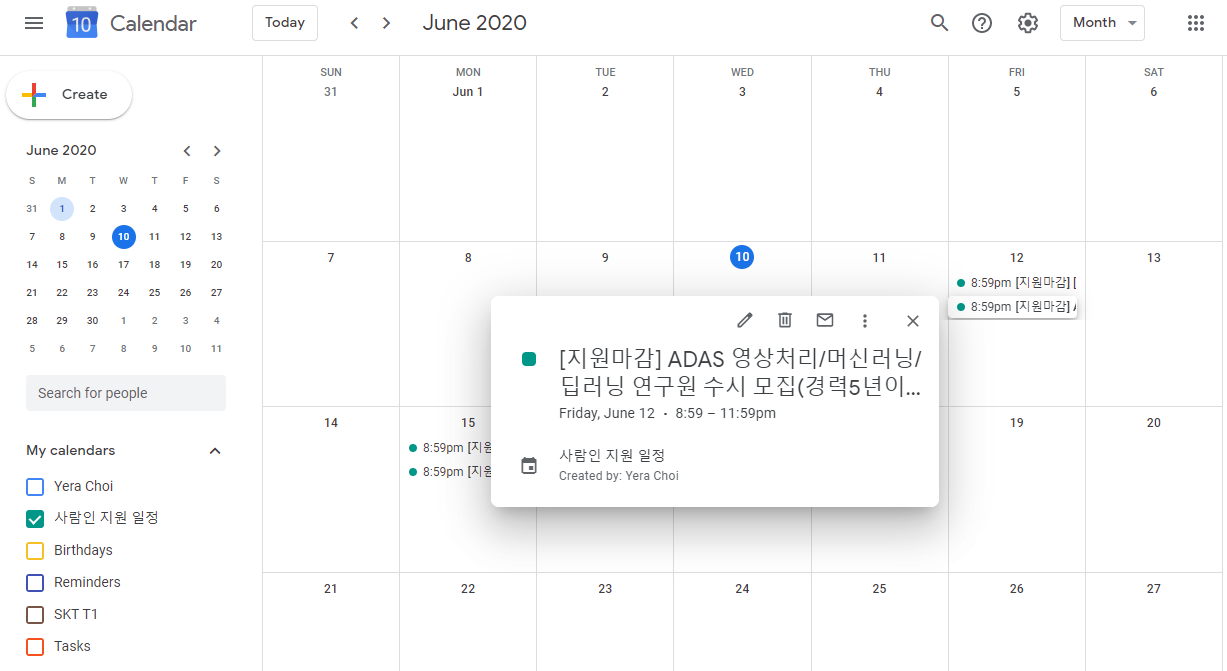

In [50]:
display(Image('./images/saramin_10_calendar.png'))

# 감사합니다!